# Enrichment analysis

First, switch to the right kernel by clicking on the button in the top 
right corner with "Python 3 (ipykernel)" and switch to "omics_predoc_course".

In this notebook, we will perform over-representation analysis 
using geneontologies [website](https://geneontology.org/) API. 

The function to query the API has already been made for you and 
can be found in `enrichment.py`.

First, we load the packages and functions needed for this 
analysis and plotting of the results:

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from enrichment import get_ora


sns.set_theme()

After loading the packages/functions, we open the DESeq2 results as follows:

In [2]:
df_lfc = pd.read_csv("../Output/DESeq2/dds_results.csv", dtype={"strain": str})
df_lfc

,gene_id,baseMean,log2fc,lfcSE,stat,pvalue,padj,strain,comparison,regulation
0,PA0001,7497.453891,-1.255825,0.440196,-2.852879,0.004333,0.027713,083.2,MvsP,Down
1,PA0002,8046.113309,-0.647908,0.403602,-1.605313,0.108425,0.265566,083.2,MvsP,NaN
2,PA0003,10157.302540,-2.079303,0.589745,-3.525768,0.000422,0.004619,083.2,MvsP,Down
3,PA0004,20884.917425,-1.072403,0.444089,-2.414835,0.015742,0.072595,083.2,MvsP,NaN
4,PA0005,785.626244,-0.429731,0.250162,-1.717806,0.085832,0.230001,083.2,MvsP,NaN
...,...,...,...,...,...,...,...,...,...,...
100129,PA5566,9.642597,-1.023313,0.587180,-1.742758,0.081376,0.298740,816.3,CvsM,NaN
100130,PA5567,603.171461,0.071818,0.333128,0.215586,0.829310,0.960576,816.3,CvsM,NaN
100131,PA5568,13366.702176,0.175758,0.468417,0.375216,0.707500,0.902706,816.3,CvsM,NaN
100132,PA5569,9019.910169,0.239277,0.246544,0.970524,0.331785,0.642922,816.3,CvsM,NaN


Then, we use the `get_ora()` function found in `enrichment.py` to get the 
GO terms for significantly up- or down-regulated genes:

In [3]:
df_go_terms = (
    df_lfc
    .query("padj < 0.05 and abs(log2fc) > 1 and ~(strain == '090.3' and comparison in ['CvsM', 'MvsP'])")
    .groupby(["strain", "comparison"])
    .gene_id
    .apply(get_ora)
    .reset_index()
    .drop(columns="level_2")
)

In [5]:
df_go_terms

,strain,comparison,number_in_list,fold_enrichment,fdr,expected,number_in_reference,pValue,term,plus_minus
0,083.2,CvsM,8,12.337029,0.000258,0.648454,22,1.081102e-07,pigment biosynthetic process (GO:0046148),+
1,083.2,CvsM,8,12.337029,0.000129,0.648454,22,1.081102e-07,heme biosynthetic process (GO:0006783),+
2,083.2,CvsM,8,10.052394,0.000526,0.795830,27,6.617052e-07,pigment metabolic process (GO:0042440),+
3,083.2,CvsM,8,10.052394,0.000395,0.795830,27,6.617052e-07,heme metabolic process (GO:0042168),+
4,083.2,CvsM,8,9.693380,0.000431,0.825306,28,9.033424e-07,porphyrin-containing compound biosynthetic pro...,+
...,...,...,...,...,...,...,...,...,...,...
38187,816.3,MvsP,10,0.930559,1.000000,10.746226,101,1.000000e+00,positive regulation of biosynthetic process (G...,-
38188,816.3,MvsP,15,0.992815,1.000000,15.108555,142,1.000000e+00,negative regulation of cellular process (GO:00...,-
38189,816.3,MvsP,8,0.916941,1.000000,8.724659,82,1.000000e+00,DNA-templated transcription (GO:0006351),-
38190,816.3,MvsP,9,1.006998,1.000000,8.937455,84,1.000000e+00,positive regulation of macromolecule metabolic...,+


We can plot the results of enrichment analysis for specific strain and comparison like below:

In [8]:
df_go_terms.query("strain == @strain and comparison == @comparison and fdr < 0.1")

,strain,comparison,number_in_list,fold_enrichment,fdr,expected,number_in_reference,pValue,term,plus_minus
2387,083.2,CvsP,20,5.113501,4.226249e-08,3.911215,31,1.770527e-11,protein secretion by the type VI secretion sys...,+


In [18]:
df_go_terms.query("term.str.contains('GO:1902222')").term.str.wrap(40)

292      erythrose\n4-phosphate/phosphoenolpyruvate fam...
3103     erythrose\n4-phosphate/phosphoenolpyruvate fam...
6346     erythrose\n4-phosphate/phosphoenolpyruvate fam...
7707     erythrose\n4-phosphate/phosphoenolpyruvate fam...
10140    erythrose\n4-phosphate/phosphoenolpyruvate fam...
11951    erythrose\n4-phosphate/phosphoenolpyruvate fam...
14639    erythrose\n4-phosphate/phosphoenolpyruvate fam...
16989    erythrose\n4-phosphate/phosphoenolpyruvate fam...
19298    erythrose\n4-phosphate/phosphoenolpyruvate fam...
22309    erythrose\n4-phosphate/phosphoenolpyruvate fam...
24585    erythrose\n4-phosphate/phosphoenolpyruvate fam...
27031    erythrose\n4-phosphate/phosphoenolpyruvate fam...
29401    erythrose\n4-phosphate/phosphoenolpyruvate fam...
31877    erythrose\n4-phosphate/phosphoenolpyruvate fam...
34932    erythrose\n4-phosphate/phosphoenolpyruvate fam...
37355    erythrose\n4-phosphate/phosphoenolpyruvate fam...
Name: term, dtype: object

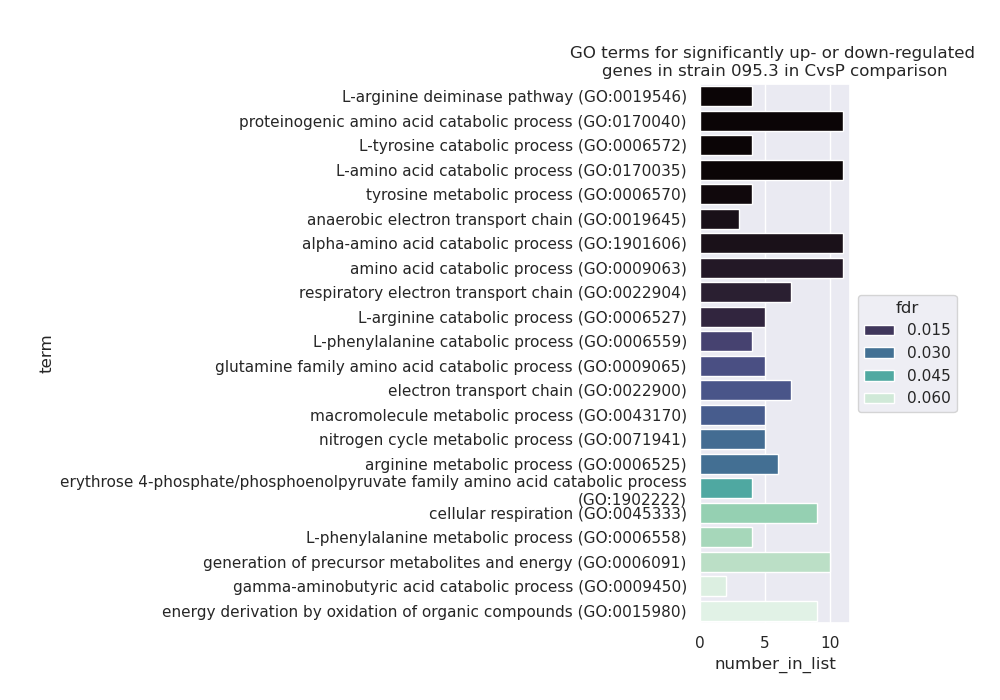

In [20]:
strain = "095.3"
comparison = "CvsP"

fig, ax = plt.subplots(figsize=(10, 7))
fig.subplots_adjust(left=0.7, right=0.85)
ax.set(title=(
    "GO terms for significantly up- or down-regulated \n"
    f"genes in strain {strain} in {comparison} comparison"
))
sns.barplot(
    df_go_terms
    .query("strain == @strain and comparison == @comparison and fdr < 0.1")
    .sort_values("fdr")
    .assign(term=lambda x: x.term.str.wrap(80)),
    y="term",
    x="number_in_list", 
    hue="fdr",
    palette="mako"
)
sns.move_legend(ax, loc="center left", bbox_to_anchor=(1.0, 0.5))

We want to see which significant GO terms are in common between strains for 
each comparison. Hence, we select GO terms significant go terms that appear 
in at least two strains and we pivot the table such that we can plot a heatmap.

In [21]:
comp_map = {
    "CvsP": 1,
    "MvsP": 2,
    "CvsM": 3,
    "CvsP, MvsP": 4,
    "CvsM, CvsP": 5,
    "CvsM, MvsP": 6,
    "CvsM, CvsP, MvsP": 7
}

df_go_heatmap = (
    df_go_terms
    .pipe(lambda x: x.merge(
        x
        .query("fdr < 0.01")
        .pivot_table(index=["comparison", "term"], values="strain", aggfunc=list)
        .reset_index()
        .assign(num_strains=lambda y: y.strain.apply(len))
        .explode("strain"),
        how="left",
        on=["term", "comparison", "strain"]
    ))
    .query("fdr < 0.01 and num_strains > 1")
    .pivot_table(index="term", columns="strain", values="comparison", aggfunc=", ".join)
    .replace(comp_map)
)

/tmp/ipykernel_103/2895689465.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(comp_map)


Finally we plot the heatmap:

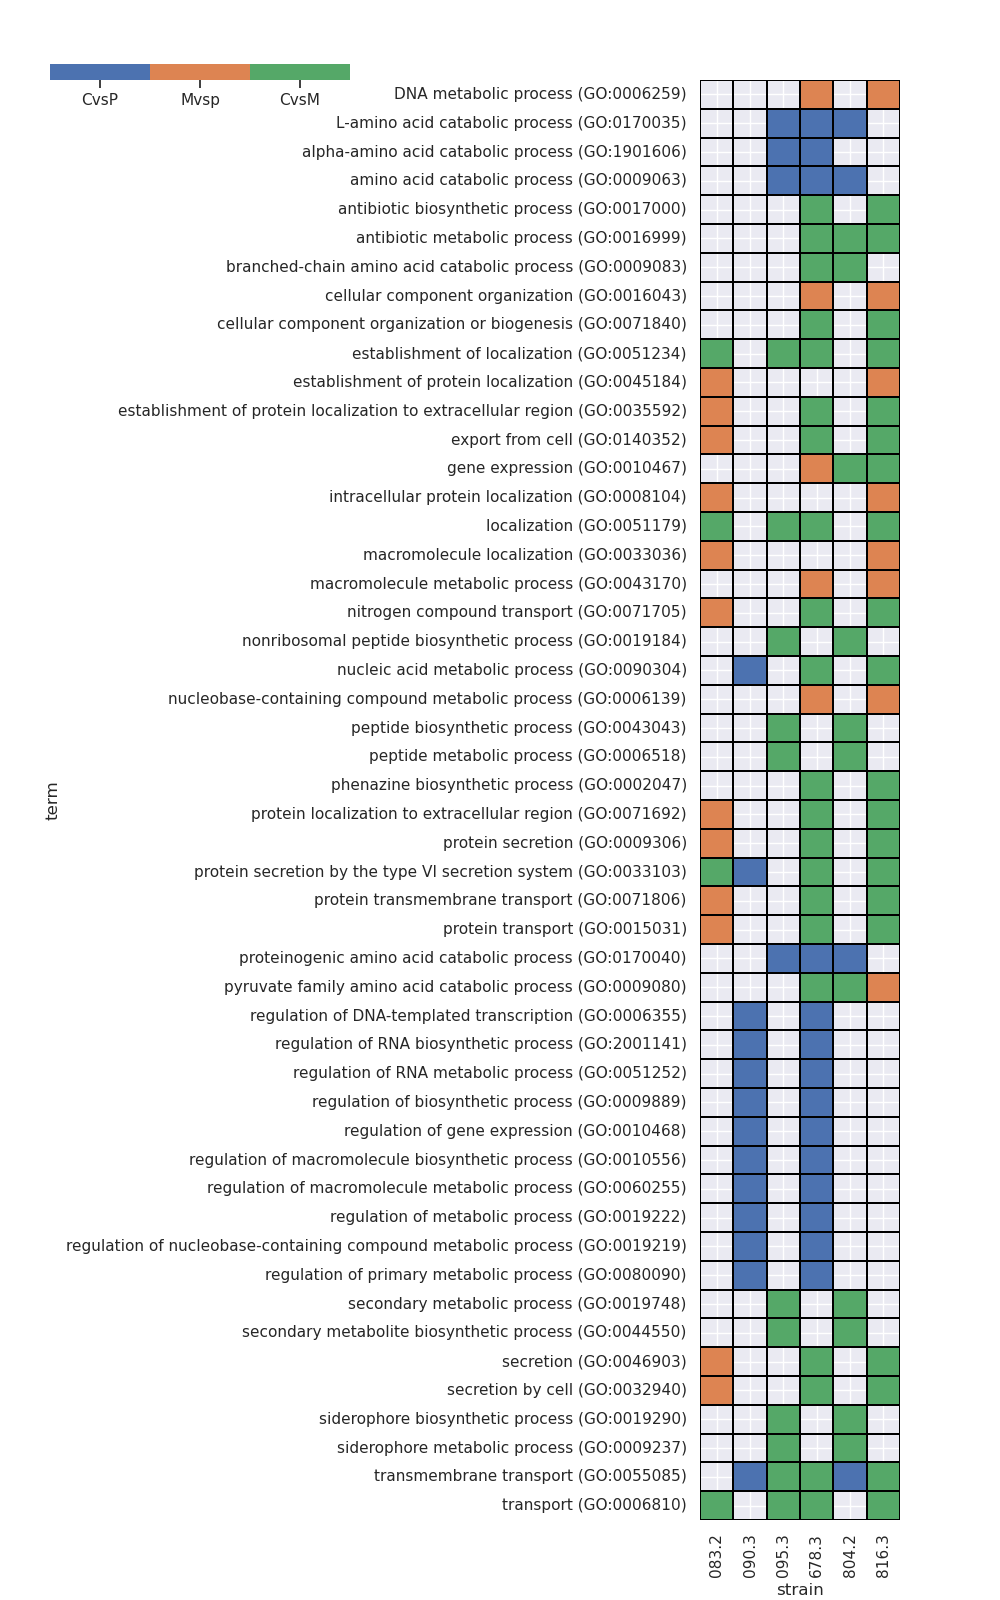

In [22]:
fig, ax = plt.subplots(figsize=(10, 16))
fig.subplots_adjust(left=0.7, top=0.95, bottom=0.05)
cbar_ax = fig.add_axes([0.05, 0.95, 0.3, 0.01])

sns.heatmap(
    df_go_heatmap,
    cmap=sns.color_palette("deep", 3), 
    linecolor="black",
    linewidths=0.3,
    vmin=0.5,
    vmax=3.5,
    cbar=True,
    cbar_ax=cbar_ax,
    cbar_kws=dict(orientation="horizontal"),
    ax=ax
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1, 2, 3])
colorbar.set_ticklabels(["CvsP", "Mvsp", "CvsM"])

Tasks:
- what conclusions can you draw from the above heatmap?
- try changing the significance threshold or number of strains with which a given GO term is associated with

The next notebook is [03_plsda](03_plsda.ipynb).